In [1]:
import cloudscraper
import re
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(8281)


# Exploring NFL odds
I'm looking at NFL odds, particularly the question of how the betting public does betting on the NFL. The question, that I've previously asked about the NBA, is do they do better or worse than a coin flip?


## getting the data
I'm trying to get NFL odds from yahoo, which I previously used to get NBA odds... of course the UX of the page and the backend calls for data are totally different than NBA, because yahoo

these urls contain the line, but not the betting percentages.
https://graphite.sports.yahoo.com/v1/query/shangrila/moduleGame?lang=en-US&region=US&ysp_platform=next-app-sports&gameId=nfl.g.20251225028

for comparison, the NBA one with all the gold is:

    return f"https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds={game_id}"

I wonder if this works...

https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds=nfl.g.20251225028


Wait, holy cow, it does (see below)! I can use that endpoint as an `undocumented API` for NFL betting data


here is a sample NFL game ID: `nfl.g.20251225028`

so like the NBA code, it will go through each calendar page, scrape the game IDs out of the HTML, then query the above endpoint for the details and parse it into JSON

In [2]:
#import scrape_yahoo
# SAMPLE_NFL_GAME = "nfl.g.20251225028"

# url = scrape_yahoo.make_yahoo_json_url(SAMPLE_NFL_GAME)
# json_data = scrape_yahoo.get_some_json(url)
# parsed = scrape_yahoo.parse_yahoo_data(json_data)

the parsing from NBA works flawlessly (as far as I can tell)

In [3]:
# parsed

### week by week calendar function to get game ids
here is week 2 of the current season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2

here is week 2 of the 2022 season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2&scoreboardSeason=2022

`dateRange` is the week of the season. I don't know what `schedState` is for

this gets 25 game ids...

the scrape_yahoo logic will ignore a game if we've already fetched it. just gotta make sure that it's only doing the current year (eg 2022 games only)

I should probably refactor the code to be a class, etc. but this is easier.

In [4]:
from scrape_yahoo import *

I'm just overriding some functions from the NBA code here. If this were production code rather than a one-off exploration, I'd convert the yahoo code to a class and do it right.

In [5]:
def make_date_url(week, year):
    return f"https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange={week}&schedState=2&scoreboardSeason={year}"

def get_yahoo_ids_for_date(week, year):
    """
    NFL VERSION

    fetches date_url and extracts all game ids out of the HTML. takes week and year as args
    """
    scraper = cloudscraper.create_scraper()
    date_url = make_date_url(week, year)
    date_html = scraper.get(date_url).text
    game_ids1 = set(re.findall(f"nfl\.g\.{year}[\d]+", date_html))
    ## some games take place in the next calendar year
    game_ids2 = set(re.findall(f"nfl\.g\.{year + 1}[\d]+", date_html))

    return game_ids1.union(game_ids2)


def fetch_yahoo_data(dir, year):
    """
    NFL version

    fetches all data from `start` to `end` and saves them as JSON in the `dir` directory.
    """
    for week in range(1, 19):
        yahoo_ids = get_yahoo_ids_for_date(week, year)
        time.sleep(2)

        for yahoo_game_id in yahoo_ids:
            cache_path = f"{dir}/{yahoo_game_id}.json"
            if not os.path.exists(cache_path):
                game_url = make_yahoo_json_url(yahoo_game_id)
                #print(f"fetching url {game_url}")
                try:
                    game_json = get_some_json(game_url)

                    with open(cache_path, "w") as f:
                        json.dump(game_json, f)
                except:
                    print(f"failed on {game_url}")
                    # I'm not sure if it's hitting rate limits or what, but might as well
                    # take a little break.
                    time.sleep(10)
                time.sleep(1) # be polite

        print(f"DONE WITH week {week}")


fetch_yahoo_data occasionally hits errors. there are a few games missing

I manually ran this for all 5 seasons.

had to re-run it to pick up some missing games.

In [6]:
FETCH = False # stop trying to make fetch happen


if FETCH:
    for yyyy in range(2021, 2026):
        print(f">>>>> ON YEAR {yyyy}")
        fetch_yahoo_data(dir=f"nfl_scrapes/{yyyy}", year=yyyy)

more code I had to clobber from the original NBA code

In [7]:
def preparse_rules():
    """
    turning the JSONPath expression into a function is costly, so it is
    important to cache it.
    """
    parsed = {}
    for k, v in scrape_rules.RULES.items():
        jsonpath_expression = parse(v)
        parsed[k] = jsonpath_expression
    return parsed

def parse_yahoo_data(json_data, filename='', parsed_rules=None):
    """
    takes json data from a single game and parses it

    it returns None for postponed/non-completed games, otherwise JSON
    """
    row = {}
    if not parsed_rules:
        parsed_rules = preparse_rules()

    for k, jsonpath_expression in parsed_rules.items():
        try:
            results = [item.value for item in jsonpath_expression.find(json_data)][0]
            row[k] = results
        except:
            print(f"file: {filename} failed on {jsonpath_expression}")

    # FIXME here: this line is the problem.. I don't think we actually want to 
    # exclude files with no total_over/total_under_won
    # if ('total_over_won' in row) and (row['total_over_won'] or row['total_under_won']):
    #     return row
    # else:
    #     return None # nobody won (postponed game) or yahoo missing data
    return row

def make_dataframe(json_filenames):
    dataframes = []
    #df = pd.DataFrame(columns=DATAFRAME_CONF.keys())
    parsed_data = None

    parsed_rules = preparse_rules()

    for filename in json_filenames:
        with open(filename, 'r') as f:
            json_data = json.load(f)
        parsed_data = parse_yahoo_data(json_data, filename, parsed_rules)
        if parsed_data: # skip if bad/no data from this file
            dataframes.append(pd.DataFrame({k:[v] for k,v in parsed_data.items()}))
        else:
            print(f"fialed on {filename}")

    return pd.concat(dataframes)

there is an error parsing this one game:
`file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'under_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value`

it doesn't have the `FULL_GAME` odds, only the live odds

## gotta catch em all

there are 1360 games total across the 5 nfl seasons

In [8]:
all_filenames = get_cached_filenames("nfl_scrapes/*")

In [9]:
len(all_filenames)

1360

get all of them in one big df.. this takes 10ish seconds

In [10]:
dataframes = []

for year in range(2021,2026):
    filenames = get_cached_filenames(f"nfl_scrapes/{year}")
    df = make_dataframe(filenames)
    df['season'] = year
    dataframes.append(df)

df_all = add_spread_columns(pd.concat(dataframes))


file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].stakePercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].wagerPercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].opti

In [11]:
len(df_all)

1360

In [12]:
df_all.head(5)

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_won,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name
0,nfl.g.20210909027,2021-09-09 07:00:00,Dallas,Tampa Bay,"-9, O/U 52.5",52.5,45.48,54.45,-110.0,1.910,...,False,False,HOME,False,False,Tampa Bay,Dallas,Dallas,Tampa Bay,Tampa Bay
0,nfl.g.20210912001,2021-09-12 07:00:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110.0,1.910,...,False,False,HOME,False,False,Atlanta,Philadelphia,Philadelphia,Atlanta,Atlanta
0,nfl.g.20210912002,2021-09-12 07:00:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48.0,87.16,90.98,-110.0,1.910,...,False,False,HOME,False,False,Buffalo,Pittsburgh,Pittsburgh,Buffalo,Buffalo
0,nfl.g.20210912004,2021-09-12 07:00:00,Minnesota,Cincinnati,"-3, O/U 47",47.0,NaN,NaN,-110.0,1.910,...,False,False,AWAY,False,False,Minnesota,Cincinnati,Cincinnati,Minnesota,Minnesota
0,nfl.g.20210912008,2021-09-12 07:00:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110.0,1.910,...,True,False,AWAY,True,False,San Francisco,Detroit,San Francisco,Detroit,San Francisco


In [13]:
17 * 16 # 17 games a season, 32 teams (so 16 games)

272

we're not missing any games now (there was a bug but I fixed it )

In [14]:
df_all.groupby('season').count()

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_won,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name
season,,,,,,,,,,,,,,,,,,,,,
2021,272,272,272,272,272,272,205,205,272,272,...,272,272,206,272,272,272,272,272,272,272
2022,272,272,272,272,272,271,255,255,271,271,...,272,272,256,272,272,271,271,272,272,272
2023,272,272,272,272,272,272,214,214,272,272,...,272,272,214,272,272,272,272,272,272,272
2024,272,272,272,272,272,272,272,272,272,272,...,272,272,272,272,272,272,272,272,272,272
2025,272,272,272,272,272,272,272,272,272,272,...,272,272,272,272,272,272,272,272,272,272


In [15]:
df_all = add_spread_columns(df_all)

In [16]:
df_all.spread_popular_won.isna().any()

np.False_

In [158]:
df_all.spread_popular_won.value_counts()

spread_popular_won
False    755
True     605
Name: count, dtype: int64

overall, the less popular side (by wager percentage) wins 55.4% of the time!

In [18]:
## this is copy/pasted from another project I don't want to import here

from scipy.stats import norm

def win_loss_report(wins, losses, vig=1.1):
    win_pct = wins / (wins+losses)
    expected_wins = (wins + losses) /2
    std = np.sqrt(wins + losses)/2 # sqrt(n*p*(1-p)) = sqrt(n * .5 * .5) = sqrt(n)/2
    z_score = (wins-expected_wins) / std
    p_value = norm.cdf(z_score)
    profit_pct = 100 * (win_pct - (vig * (1-win_pct)))

    # betting markets are more like visa/mastercard. the side getting paid covers 
    # the cost for facilitating the transaction.

    # there isn't necessarily vig on the bet itself, because you are betting
    # against another person, not the house.

    # however, people who provide liquidity for the betting market want to make money 
    # for their troubles, so there is usually a little bit of vig.
     
    # On matchbook.com, this appears to be around .3%-.7% for NBA basketball. 
    # eg. [+102/-105.26] for spread or [-208/+205] for money line

    # On ProphetX (newish market, low volume), it is around .2% on big events
    # eg [-112/+111] on the superbowl ML right now
    # but closer to 1.2-1.7% on NBA: [-107/+102] --1.1%, [-103/-102] --1.2%, [100/-105] --1.2% 
    # [-101, -106] -- 1.7%

    # On novig (new market, almost no volume), they are like [-105/-104] - 2.2%, [+109/-127] - 3.7% 
    # [-108/-105] - 3%

    # I am estimating it at 1.7%.

    betting_market = (.97*wins) - (1.017 * losses)

    print(f"record:   {wins} - {losses}")
    if vig != 1.1:
        print(f"actual ({vig} vig) units: { round(wins - (vig*losses), 2)}")
    
    print(f"full vig (-110) units: { round(wins - (1.1*losses),2) }")
    print(f"reduced juice (-106) : { round(wins - (1.06 * losses),2) }")
    print(f"reduced juice (-105) : { round(wins - (1.05 * losses),2) }")
    print(f"betting market       : { round(betting_market, 2) }")

    print(f"win pct: {round(100 *win_pct,2)}%, expected wins: {expected_wins}")
    print(f"excess: {wins - expected_wins}, profit %: {round(profit_pct,2)}")
    print(f"z test: {round(z_score,2)}, std: {round(std,2)} , p-value: {round(1-p_value, 4)}")



In [161]:
win_loss_report(755,605)

record:   755 - 605
full vig (-110) units: 89.5
reduced juice (-106) : 113.7
reduced juice (-105) : 119.75
betting market       : 117.07
win pct: 55.51%, expected wins: 680.0
excess: 75.0, profit %: 6.58
z test: 4.07, std: 18.44 , p-value: 0.0


In [20]:
season_grouper = df_all.groupby("season")

In [21]:
season_grouper["spread_popular_won"].value_counts()

season  spread_popular_won
2021    False                 164
        True                  108
2022    False                 152
        True                  120
2023    False                 167
        True                  105
2024    True                  143
        False                 129
2025    False                 143
        True                  129
Name: count, dtype: int64

In [22]:
df_all.spread_popular_won.value_counts()

spread_popular_won
False    755
True     605
Name: count, dtype: int64

In [23]:
result_percents = season_grouper["spread_popular_won"].value_counts() / season_grouper.count()['spread_popular_won']

In [24]:
result_percents

season  spread_popular_won
2021    False                 0.602941
        True                  0.397059
2022    False                 0.558824
        True                  0.441176
2023    False                 0.613971
        True                  0.386029
2024    True                  0.525735
        False                 0.474265
2025    False                 0.525735
        True                  0.474265
dtype: float64

here are winning percentages by year for the less popular team (by wager percentage)

that's been a winning proposition in 4/5 years. kind of impressive (or a bug in my code, LOL)

In [25]:
fade_win_pct = result_percents[:, False] # False means the popular side didn't win

fade_win_pct

season
2021    0.602941
2022    0.558824
2023    0.613971
2024    0.474265
2025    0.525735
dtype: float64

In [26]:
fade_win_pct.values

array([0.60294118, 0.55882353, 0.61397059, 0.47426471, 0.52573529])

confidence interval for each season

In [27]:
from statsmodels.stats.proportion import proportion_confint

ci = proportion_confint(count=.5*272, nobs=272, alpha=.1)


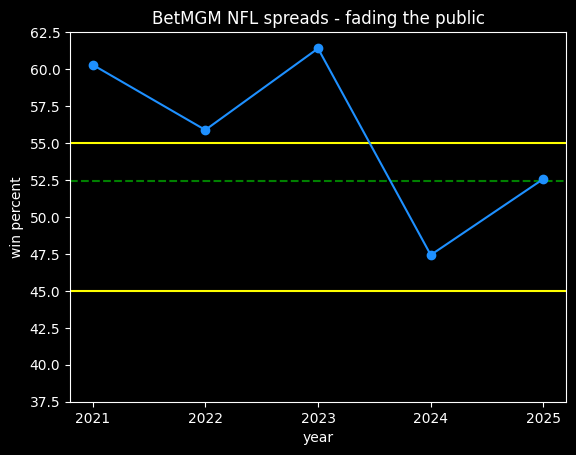

In [28]:
plt.style.use('dark_background')

plt.title("BetMGM NFL spreads - fading the public")
plt.xlabel("year")
plt.ylabel("win percent")
plt.xticks(fade_win_pct.index)
plt.yticks(np.arange(37.5, 65, 2.5))
plt.ylim([37.5,62.5])
plt.axhline(52.4, color='green', linestyle="--")
plt.axhline(100 * ci[0], color='yellow')
plt.axhline(100 * ci[1], color='yellow')
plt.plot(fade_win_pct.index, fade_win_pct.values * 100, "o-", color='dodgerblue')

can do the same thing for stake percentage

In [29]:
(season_grouper['spread_stake_won'].value_counts() / season_grouper.count()['spread_stake_won'])[:, False]

season
2021    0.591912
2022    0.573529
2023    0.617647
2024    0.496324
2025    0.481618
dtype: float64

are there other patterns to be found? what about games where they differ?

In [30]:
df_all[df_all.spread_stake_won != df_all.spread_popular_won].spread_stake_won.value_counts()

spread_stake_won
True     107
False    103
Name: count, dtype: int64

what if we only look at games where there's consensus between them?

In [31]:
consensus = df_all[df_all.spread_stake_won == df_all.spread_popular_won]

consensus.spread_stake_won.value_counts()

spread_stake_won
False    648
True     502
Name: count, dtype: int64

In [32]:
consensus_win_pct = (consensus.groupby('season')['spread_stake_won'].value_counts() / 
    consensus.groupby('season').count()['spread_stake_won'])[:, False]

In [33]:
consensus_win_pct

season
2021    0.611814
2022    0.579646
2023    0.631799
2024    0.482759
2025    0.504630
dtype: float64

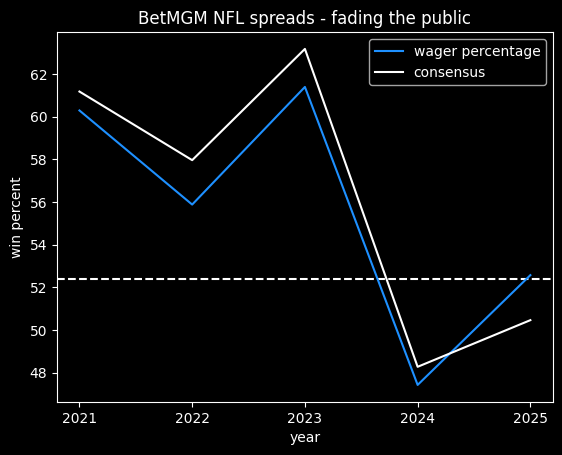

In [34]:
plt.style.use('dark_background')

plt.title("BetMGM NFL spreads - fading the public")
plt.xlabel("year")
plt.ylabel("win percent")
plt.xticks(fade_win_pct.index)
plt.axhline(52.4, color='white', linestyle="--")
plt.plot(fade_win_pct.index, fade_win_pct.values * 100, color='dodgerblue', label="wager percentage")
plt.plot(consensus_win_pct.index, consensus_win_pct.values * 100, color='white', label="consensus")
plt.legend()


when majority num bets and stake agree, the win rate goes up to 56.4%, and is slightly more profitable (+113.6 vs +110.48)

In [35]:
win_loss_report(649,500)

record:   649 - 500
full vig (-110) units: 99.0
reduced juice (-106) : 119.0
reduced juice (-105) : 124.0
betting market       : 121.03
win pct: 56.48%, expected wins: 574.5
excess: 74.5, profit %: 8.62
z test: 4.4, std: 16.95 , p-value: 0.0


the dichotomous nature of the data (home vs. away) can sometimes make analysis confusing

In [36]:
df_all[df_all.spread_home_wager_percentage > 50].spread_popular_won.value_counts()

spread_popular_won
True     250
False    246
Name: count, dtype: int64

In [37]:
df_all[df_all.spread_home_wager_percentage <= 50].spread_popular_won.value_counts()

spread_popular_won
False    368
True     355
Name: count, dtype: int64

In [38]:
df_all.spread_dog_won.value_counts()

spread_dog_won
True     687
False    673
Name: count, dtype: int64

NFL bettors vastly prefer taking the away team, which is odd to me, but I saw the same thing with the NBA

In [39]:
df_all.spread_most_popular.value_counts()

spread_most_popular
AWAY    724
HOME    496
Name: count, dtype: int64

In [40]:
723 / (723 + 496)

0.5931091058244463

this isn't that interesting because the away team is more likely to be the underdog due to home field advantage

In [41]:
pd.crosstab(df_all.spread_dog_won, df_all.spread_home_won)

spread_home_won,False,True
spread_dog_won,,
False,275,398
True,427,260


how often do they take dogs versus favorites?

In [42]:
df_all.spread_popular_underdog.value_counts()

spread_popular_underdog
False    877
True     483
Name: count, dtype: int64

In [43]:
win_loss_report(880,480)

record:   880 - 480
full vig (-110) units: 352.0
reduced juice (-106) : 371.2
reduced juice (-105) : 376.0
betting market       : 365.44
win pct: 64.71%, expected wins: 680.0
excess: 200.0, profit %: 25.88
z test: 10.85, std: 18.44 , p-value: 0.0


## looking at some more basic divisions in the data

In [44]:
df_all.columns[df_all.columns.str.contains("won")]

Index(['total_over_won', 'total_under_won', 'money_away_won', 'money_home_won',
       'spread_away_won', 'spread_home_won', 'spread_dog_won',
       'spread_popular_won', 'spread_stake_won'],
      dtype='object')

In [45]:
df_all.spread_home_won.value_counts()

spread_home_won
False    702
True     658
Name: count, dtype: int64

In [46]:
win_loss_report(650,710)

record:   650 - 710
full vig (-110) units: -131.0
reduced juice (-106) : -102.6
reduced juice (-105) : -95.5
betting market       : -91.57
win pct: 47.79%, expected wins: 680.0
excess: -30.0, profit %: -9.63
z test: -1.63, std: 18.44 , p-value: 0.9481


In [47]:
df_all.spread_dog_won.value_counts()

spread_dog_won
True     687
False    673
Name: count, dtype: int64

In [48]:
win_loss_report(681,679)

record:   681 - 679
full vig (-110) units: -65.9
reduced juice (-106) : -38.74
reduced juice (-105) : -31.95
betting market       : -29.97
win pct: 50.07%, expected wins: 680.0
excess: 1.0, profit %: -4.85
z test: 0.05, std: 18.44 , p-value: 0.4784


what about home dogs?

In [49]:
df_all[df_all.spread_home_points > 0].spread_home_won.value_counts()

spread_home_won
False    275
True     260
Name: count, dtype: int64

In [50]:
win_loss_report(257,278)

record:   257 - 278
full vig (-110) units: -48.8
reduced juice (-106) : -37.68
reduced juice (-105) : -34.9
betting market       : -33.44
win pct: 48.04%, expected wins: 267.5
excess: -10.5, profit %: -9.12
z test: -0.91, std: 11.57 , p-value: 0.818


how about team records against the spread?

In [51]:
# this is a bad way to do this

# a1 = pd.DataFrame(df_all.groupby("away_team")["spread_away_won"].value_counts()).reset_index().rename(columns={'away_team': 'team', 'spread_away_won': 'won'})
# a2 = pd.DataFrame(df_all.groupby("home_team")["spread_home_won"].value_counts()).reset_index().rename(columns={'home_team': 'team', 'spread_home_won': 'won'})

In [52]:
num_games = df_all.spread_winner_team_name.value_counts() + df_all.spread_loser_team_name.value_counts()

In [53]:
record_ats = df_all.spread_winner_team_name.value_counts() /num_games

In [54]:
record_ats.sort_values(ascending=False)

Detroit          0.635294
Pittsburgh       0.576471
Dallas           0.552941
Cincinnati       0.552941
LA Rams          0.552941
Minnesota        0.552941
LA Chargers      0.541176
Green Bay        0.529412
San Francisco    0.529412
Jacksonville     0.517647
Philadelphia     0.517647
Seattle          0.517647
Buffalo          0.517647
Arizona          0.517647
Indianapolis     0.505882
Baltimore        0.505882
Miami            0.505882
New England      0.494118
Houston          0.494118
Las Vegas        0.482353
NY Giants        0.482353
Denver           0.482353
Washington       0.470588
New Orleans      0.470588
Cleveland        0.458824
Kansas City      0.458824
Chicago          0.447059
Tampa Bay        0.447059
Carolina         0.435294
Atlanta          0.423529
Tennessee        0.423529
NY Jets          0.400000
Name: count, dtype: float64

### how do teams do when they're the popular team?

In [55]:
df_all.columns

Index(['game_id', 'game_date', 'away_team', 'home_team', 'pregame_odds',
       'total_over_points', 'total_over_stake_percentage',
       'total_over_wager_percentage', 'total_over_odds',
       'total_over_decimal_odds', 'total_over_won', 'total_under_points',
       'total_under_stake_percentage', 'total_under_wager_percentage',
       'total_under_odds', 'total_under_decimal_odds', 'total_under_won',
       'money_away_odds', 'money_away_decimal_odds',
       'money_away_stake_percentage', 'money_away_wager_percentage',
       'money_away_won', 'money_home_odds', 'money_home_decimal_odds',
       'money_home_stake_percentage', 'money_home_wager_percentage',
       'money_home_won', 'spread_away_points', 'spread_away_odds',
       'spread_away_decimal_odds', 'spread_away_stake_percentage',
       'spread_away_wager_percentage', 'spread_away_won', 'spread_home_points',
       'spread_home_odds', 'spread_home_decimal_odds',
       'spread_home_stake_percentage', 'spread_home_wager_per

In [56]:
popular_winners = df_all[df_all.spread_winner_team_name == df_all.spread_popular_team_name].spread_popular_team_name.value_counts()

In [57]:
popular_losers = df_all[df_all.spread_loser_team_name == df_all.spread_popular_team_name].spread_popular_team_name.value_counts()

In [58]:
popular_records = pd.DataFrame({'W': popular_winners, 'L': popular_losers})

In [59]:
popular_records['win_pct'] = popular_records.W / (popular_records.W + popular_records.L)

In [60]:
popular_records.sort_values(by='win_pct')

,W,L,win_pct
spread_popular_team_name,,,
Cleveland,12,20,0.375000
Chicago,12,20,0.375000
Las Vegas,11,18,0.379310
Tampa Bay,19,31,0.380000
Atlanta,15,24,0.384615
New Orleans,11,16,0.407407
Carolina,13,18,0.419355
Houston,17,23,0.425000
Kansas City,27,32,0.457627


winning percents seem to be in a reasonable range

<Axes: >

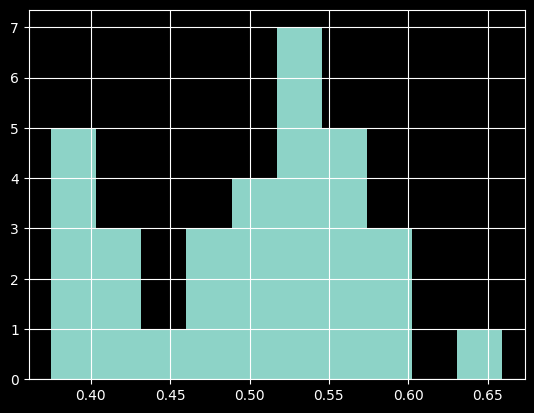

In [61]:
popular_records.win_pct.hist()

In [62]:
proportion_confint(count=15, nobs=30)


(0.32108058562828423, 0.6789194143717158)

# It wouldn't be a data science project without missing data

In [63]:
715 + 489

1204

there are 126 games that are missing bet percent data

In [64]:
len(df_all)

1360

because of that, some columns don't have `spread_most_popular` values

In [65]:
mystery_games = df_all[df_all.spread_most_popular.isna()]

these games don't have the wager percentage

In [66]:
mystery_games.spread_away_wager_percentage

0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
     ..
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
Name: spread_away_wager_percentage, Length: 140, dtype: float64

the missing games, by season

In [67]:
mystery_games.season.value_counts()

season
2021    66
2023    58
2022    16
Name: count, dtype: int64

these are a pretty significant percentage of the games in 2021 and 2023. those are the two seasons with the highest winning percentages for the unpopular side of the bets, which introduces some uncertainty

In [68]:
mystery_games.season.value_counts() / df_all.season.value_counts()

season
2021    0.242647
2022    0.058824
2023    0.213235
2024         NaN
2025         NaN
Name: count, dtype: float64

missing data leads to a confusing crosstab, because it doesn't include nulls

In [69]:
pd.crosstab(df_all.spread_popular_won, df_all.spread_most_popular)

spread_most_popular,AWAY,HOME
spread_popular_won,,
False,369,246
True,355,250


In [70]:
mystery_games.iloc[1]

game_id                           nfl.g.20210912019
game_date                       2021-09-12 07:00:00
away_team                                    Denver
home_team                                 NY Giants
pregame_odds                             -2, O/U 41
total_over_points                              41.0
total_over_stake_percentage                    60.4
total_over_wager_percentage                   78.34
total_over_odds                              -110.0
total_over_decimal_odds                       1.910
total_over_won                                False
total_under_points                             41.0
total_under_stake_percentage                   39.6
total_under_wager_percentage                  21.66
total_under_odds                             -110.0
total_under_decimal_odds                      1.910
total_under_won                                True
money_away_odds                              -160.0
money_away_decimal_odds                       1.630
money_away_s

a lot of these missing games are clustered on certain days. it would be hard to call it 'missing at random'

In [71]:
mystery_games.game_date.value_counts()

game_date
2021-10-10 07:00:00    14
2023-12-31 08:00:00    14
2024-01-07 08:00:00    14
2021-10-03 07:00:00    13
2021-09-19 07:00:00    12
2021-10-17 07:00:00    12
2023-12-24 08:00:00    10
2021-09-12 07:00:00     5
2023-10-29 07:00:00     3
2023-12-25 08:00:00     3
2022-11-27 07:00:00     3
2024-01-06 08:00:00     2
2022-09-18 06:00:00     2
2022-10-23 06:00:00     2
2023-12-23 08:00:00     2
2023-12-17 08:00:00     2
2022-10-16 06:00:00     2
2022-11-20 07:00:00     2
2021-10-07 07:00:00     1
2021-09-20 07:00:00     1
2021-09-27 07:00:00     1
2021-09-13 07:00:00     1
2021-09-30 07:00:00     1
2021-10-18 07:00:00     1
2021-10-11 07:00:00     1
2022-12-18 07:00:00     1
2022-12-11 07:00:00     1
2022-12-04 07:00:00     1
2022-09-29 06:00:00     1
2021-10-31 07:00:00     1
2022-01-02 08:00:00     1
2022-01-09 08:00:00     1
2022-09-25 06:00:00     1
2023-12-21 08:00:00     1
2023-12-16 08:00:00     1
2023-11-26 08:00:00     1
2023-11-05 07:00:00     1
2023-10-08 07:00:00     1
20

## complete info on missing data by column

the line info is complete, but wager percentages are missing for a fair number of games (not sure if the same games for all categories)

the 26 that don't have a spread winner are probably pushes?

In [72]:
df_all.isna().sum()

game_id                           0
game_date                         0
away_team                         0
home_team                         0
pregame_odds                      0
total_over_points                 1
total_over_stake_percentage     142
total_over_wager_percentage     142
total_over_odds                   1
total_over_decimal_odds           1
total_over_won                    0
total_under_points                1
total_under_stake_percentage    141
total_under_wager_percentage    141
total_under_odds                  1
total_under_decimal_odds          1
total_under_won                   0
money_away_odds                   1
money_away_decimal_odds           1
money_away_stake_percentage     139
money_away_wager_percentage     133
money_away_won                    0
money_home_odds                   1
money_home_decimal_odds           1
money_home_stake_percentage     138
money_home_wager_percentage     132
money_home_won                    0
spread_away_points          

## what about point totals?

In [73]:
df_all.total_over_won.value_counts()

total_over_won
False    702
True     658
Name: count, dtype: int64

this is quite odd... the over won 45% of the time for 3 seasons, then totally flipped

In [74]:
(season_grouper['total_over_won'].value_counts() / df_all.season.value_counts())[:, True]

season
2021    0.455882
2022    0.452206
2023    0.455882
2024    0.529412
2025    0.525735
Name: count, dtype: float64

when the public took the over, it lost 51.8% o the time

In [75]:
popular_over = df_all[df_all.total_over_wager_percentage > 50]

popular_over.total_over_won.value_counts() / len(popular_over)

total_over_won
False    0.522727
True     0.477273
Name: count, dtype: float64

In [76]:
len(popular_over)

1056

when the public took the under, it lost 53.1% of the time

In [77]:
popular_under = df_all[df_all.total_under_wager_percentage > 50]

popular_under.total_under_won.value_counts() / len(popular_under)

total_under_won
False    0.534161
True     0.465839
Name: count, dtype: float64

this isn't counting games where it's a tie...

In [78]:
df_all[df_all.total_over_wager_percentage == 50]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_won,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name
0,nfl.g.20211107014,2021-11-07 07:00:00,Tennessee,LA Rams,"-7, O/U 53.5",53.5,49.11,50.0,-110.0,1.910,...,True,True,AWAY,True,True,LA Rams,Tennessee,Tennessee,LA Rams,Tennessee
0,nfl.g.20251123014,2025-11-23 08:00:00,Tampa Bay,LA Rams,"-7, O/U 50",50.0,67.06,50.0,-110.0,1.910,...,False,True,AWAY,False,True,LA Rams,Tampa Bay,LA Rams,Tampa Bay,Tampa Bay


In [79]:
len(popular_under)

161

In [80]:
consensus_over = df_all[(df_all.total_over_wager_percentage > 50) & (df_all.total_over_stake_percentage > 50)]

In [81]:
consensus_over.total_over_won.value_counts() / len(consensus_over)

total_over_won
False    0.527311
True     0.472689
Name: count, dtype: float64

In [82]:
consensus_under = df_all[(df_all.total_under_wager_percentage > 50) & (df_all.total_under_stake_percentage > 50)]
consensus_under.total_under_won.value_counts() / len(consensus_under)

total_under_won
True     0.5
False    0.5
Name: count, dtype: float64

what's the over/under rate by total? do higher totals go under more?

In [83]:
sum(df_all.total_over_points != df_all.total_under_points)

1

In [84]:
df_all.total_over_points.describe()

count    1359.000000
mean       44.272259
std         4.664973
min        22.500000
25%        41.500000
50%        44.500000
75%        47.500000
max        62.500000
Name: total_over_points, dtype: float64

In [85]:
df_all.total_over_points.mean()

np.float64(44.27225901398087)

In [86]:
df_all[df_all.total_over_points >= df_all.total_over_points.median()].total_over_won.value_counts()

total_over_won
False    370
True     320
Name: count, dtype: int64

In [87]:
win_loss_report(360,316)

record:   360 - 316
full vig (-110) units: 12.4
reduced juice (-106) : 25.04
reduced juice (-105) : 28.2
betting market       : 27.83
win pct: 53.25%, expected wins: 338.0
excess: 22.0, profit %: 1.83
z test: 1.69, std: 13.0 , p-value: 0.0453


In [88]:
df_all[df_all.total_over_points < df_all.total_over_points.median()].total_over_won.value_counts()

total_over_won
True     337
False    332
Name: count, dtype: int64

In [89]:
win_loss_report(333 + 360, 321 + 316)

record:   693 - 637
full vig (-110) units: -7.7
reduced juice (-106) : 17.78
reduced juice (-105) : 24.15
betting market       : 24.38
win pct: 52.11%, expected wins: 665.0
excess: 28.0, profit %: -0.58
z test: 1.54, std: 18.23 , p-value: 0.0623


this is a little misleading, because there are a lot of games exactly at the median, so `>=` vs `>` makes a pretty big difference (but the naive strategy is still better than a coin flip)

In [90]:
df_all[df_all.total_over_points > df_all.total_over_points.median()].total_over_won.value_counts()

total_over_won
False    317
True     285
Name: count, dtype: int64

In [91]:
df_all[df_all.total_over_points <= df_all.total_over_points.median()].total_over_won.value_counts()

total_over_won
False    385
True     372
Name: count, dtype: int64

How off are the point totals? does that tell us anything interesting?

In [92]:
df_all.iloc[11]

game_id                           nfl.g.20210912019
game_date                       2021-09-12 07:00:00
away_team                                    Denver
home_team                                 NY Giants
pregame_odds                             -2, O/U 41
total_over_points                              41.0
total_over_stake_percentage                    60.4
total_over_wager_percentage                   78.34
total_over_odds                              -110.0
total_over_decimal_odds                       1.910
total_over_won                                False
total_under_points                             41.0
total_under_stake_percentage                   39.6
total_under_wager_percentage                  21.66
total_under_odds                             -110.0
total_under_decimal_odds                      1.910
total_under_won                                True
money_away_odds                              -160.0
money_away_decimal_odds                       1.630
money_away_s

In [93]:
df_all.columns

Index(['game_id', 'game_date', 'away_team', 'home_team', 'pregame_odds',
       'total_over_points', 'total_over_stake_percentage',
       'total_over_wager_percentage', 'total_over_odds',
       'total_over_decimal_odds', 'total_over_won', 'total_under_points',
       'total_under_stake_percentage', 'total_under_wager_percentage',
       'total_under_odds', 'total_under_decimal_odds', 'total_under_won',
       'money_away_odds', 'money_away_decimal_odds',
       'money_away_stake_percentage', 'money_away_wager_percentage',
       'money_away_won', 'money_home_odds', 'money_home_decimal_odds',
       'money_home_stake_percentage', 'money_home_wager_percentage',
       'money_home_won', 'spread_away_points', 'spread_away_odds',
       'spread_away_decimal_odds', 'spread_away_stake_percentage',
       'spread_away_wager_percentage', 'spread_away_won', 'spread_home_points',
       'spread_home_odds', 'spread_home_decimal_odds',
       'spread_home_stake_percentage', 'spread_home_wager_per

## what about money lines

add_money_columns will drop the games without the `money_home_won` field

In [94]:
df_money = add_money_columns(df_all.copy())


the public greatly prefers the favorite on the money line.

In [95]:
df_money.money_fave_dog.value_counts()

money_fave_dog
FAVE    1181
DOG       47
Name: count, dtype: int64

In [96]:
1180 + 48


1228

median money line bet is -200 (taking the mean of money line odds doesn't make sense)

In [97]:
df_money.money_popular_odds.astype('float').median()

np.float64(-200.0)

## What if a bettor always took the popular side of the money line?

I've added `*_payout` fields for the exact payout on a $100 bet

In [98]:
df_money.iloc[0]

game_id                   nfl.g.20210909027
game_date               2021-09-09 07:00:00
away_team                            Dallas
home_team                         Tampa Bay
pregame_odds                   -9, O/U 52.5
                               ...         
money_popular_odds                   -450.0
money_overround                    1.040404
money_away_payout                     350.0
money_home_payout                 22.222222
money_popular_payout              22.222222
Name: 0, Length: 62, dtype: object

In [99]:
df_money.iloc[1:5,:]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_loser_team_name,spread_popular_team_name,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout
0,nfl.g.20210912001,2021-09-12 07:00:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110.0,1.910,...,Atlanta,Atlanta,HOME,False,FAVE,-175.0,1.044527,145.000000,57.142857,57.142857
0,nfl.g.20210912002,2021-09-12 07:00:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48.0,87.16,90.98,-110.0,1.910,...,Buffalo,Buffalo,HOME,False,FAVE,-275.0,1.041026,225.000000,36.363636,36.363636
0,nfl.g.20210912004,2021-09-12 07:00:00,Minnesota,Cincinnati,"-3, O/U 47",47.0,NaN,NaN,-110.0,1.910,...,Minnesota,Minnesota,AWAY,False,FAVE,-150.0,1.044444,66.666667,125.000000,66.666667
0,nfl.g.20210912008,2021-09-12 07:00:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110.0,1.910,...,Detroit,San Francisco,AWAY,True,FAVE,-350.0,1.040936,28.571429,280.000000,28.571429


`money_converted` is how much money we'd win risking $100 on each bet. quick sanity check --

In [100]:
df_money.money_popular_odds.isna().sum()

np.int64(0)

In [101]:
df_money[df_money.money_home_wager_percentage.isna()]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_loser_team_name,spread_popular_team_name,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout


In [102]:
df_money.loc[df_money.money_popular_won, ['money_popular_payout', 'money_popular_odds', 'money_popular_won']]

,money_popular_payout,money_popular_odds,money_popular_won
0,22.222222,-450.0,True
0,28.571429,-350.0,True
0,66.666667,-150.0,True
0,40.000000,-250.0,True
0,25.000000,-400.0,True
...,...,...,...
0,9.090909,-1100.0,True
0,12.500000,-800.0,True
0,9.090909,-1100.0,True
0,12.500000,-800.0,True


the popular side doesn't do that bad, actually. they're taking median -200 odds and winning 66.4% of the time. that's a very small margin for the sportsbook -- the public is making close to the implied odds of a -200 bet.

In [103]:
df_money.money_popular_won.value_counts() / len(df_money)

money_popular_won
True     0.663681
False    0.336319
Name: count, dtype: float64

because of the wackiness of money lines, need to look at the median

In [104]:
df_money.money_popular_odds.astype(int).median()

np.float64(-200.0)

In [105]:
convert_line(-200)

0.6666666666666666

calculate profit/loss taking every money line bet

In [106]:
moneyline_profit = df_money[df_money.money_popular_won].money_popular_payout.sum() - (100 * (sum(~df_money.money_popular_won)))

In [107]:
moneyline_profit

np.float64(-3917.892512623468)

-4.2% is a little better than the usual -4.5% on spread bets

In [108]:
moneyline_profit / (100 * len(df_money))

np.float64(-0.031904662154914235)

In [109]:
df_money[df_money.money_popular_won].money_popular_payout.sum()

np.float64(37382.10748737653)

In [110]:
(100 * (sum(~df_money.money_popular_won)))

41300

## the overround

the problem is, we don't know what the vig *really* is. can I get that by looking at all money lines? yes, I can. just calculate overround for every single bet (now added to analysis code)

In [111]:
df_money.money_overround.describe()

count    1228.000000
mean        1.044359
std         0.003797
min         1.030303
25%         1.041408
50%         1.044367
75%         1.047079
max         1.059113
Name: money_overround, dtype: float64

<Axes: >

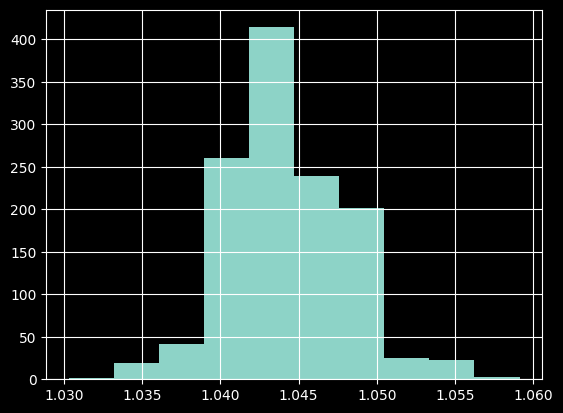

In [112]:
df_money.money_overround.hist()

On paper, it's awful close to 4.5%, just like -110 spread bets.

the public getting -3.2% does indicate they're doing better than chance, a bit.

I could prove that with a random simulation.

In [113]:

some_outcomes = []
NUM_OUTCOMES = 100


for run in range(NUM_OUTCOMES):
    random_p_l = []
    # simulate taking random money line picks, and betting $100 on them
    for idx, row in df_money.iterrows():
        # for each row, flip a virtual coin to decide side to take, then record whether it made/lost money
        home_vs_away = rng.choice(["home", "away"])
        won = row[f"money_{home_vs_away}_won"]
        if won:
            random_p_l.append(row[f"money_{home_vs_away}_payout"])
        else:
            random_p_l.append(-100)
    some_outcomes.append(random_p_l)


In [114]:
outcomes = pd.Series(map(sum, some_outcomes))

<Axes: >

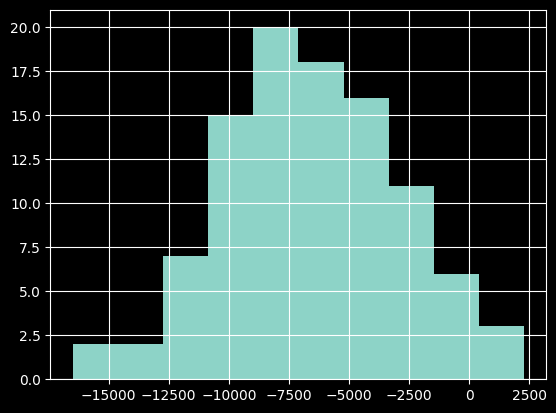

In [115]:
outcomes.hist()

so yeah, the public did better than simulation (around one std better than the mean)

In [116]:
outcomes.describe()

count      100.000000
mean     -6544.835506
std       3778.394891
min     -16481.837466
25%      -9161.458818
50%      -6085.164840
75%      -3901.325215
max       2272.334256
dtype: float64

## Investigating EV by type of money line bet

copy/pasted from explore.ipynb notebook, not really interesting enough to make its own module


In [167]:

config = {
    'all favorites': [-9999, -1],
    'mild favorites': [-200, -1],
    'heavy favorites': [-400, -200],
    'huge favorites': [-9999, -400],
    
    'all dogs': [1, 9999],
    'mild dogs': [1, 200],
    'heavy dogs': [200, 400],
    'huge dogs': [400, 9999],

    'everythang': [-9999, 9999]
}

def run_moneyline_sim(name, start, end, dataframe=df_money, quiet=False):
    net_profit = 0
    games_bet = 0
    for idx, game in dataframe.iterrows():
        num_matches = 0
        if game.money_home_odds >= start and (game.money_home_odds < end):
            profit = game.money_home_payout

            if game.money_home_won:
                net_profit = net_profit + profit
            else:
                net_profit = net_profit - 100
            games_bet +=1

            num_matches += 1

        ## note: this shouldn't be an 'elif' because both sides could be 
        if game.money_away_odds >= start and (game.money_away_odds < end):
            profit = game.money_away_payout

            if game.money_away_won:
                net_profit = net_profit + profit
            else:
                net_profit = net_profit - 100
            games_bet +=1

            num_matches += 1
        # if (num_matches == 2) and (name != "everythang"):
        #     print(f"double match on {game.money_home_odds}, {game.money_away_odds}")
    if not quiet:
        #print(f"{name} ({start}, {end}) profit is {net_profit}, games: {games_bet}, per game {net_profit/games_bet}")
        print(f"| {name} | {start} | {end} | {games_bet} | {net_profit/games_bet:.1f}% |")
    
    else:
        return net_profit/games_bet

for k,v in config.items():
    run_moneyline_sim(k, *v)

| all favorites | -9999 | -1 | 1271 | -3.9% |
| mild favorites | -200 | -1 | 662 | -2.8% |
| heavy favorites | -400 | -200 | 406 | -7.5% |
| huge favorites | -9999 | -400 | 203 | -0.2% |
| all dogs | 1 | 9999 | 1185 | -7.3% |
| mild dogs | 1 | 200 | 663 | -5.4% |
| heavy dogs | 200 | 400 | 399 | -3.4% |
| huge dogs | 400 | 9999 | 123 | -29.7% |
| everythang | -9999 | 9999 | 2456 | -5.5% |


I thought there might be a bug in the above code, but I double-checked it and I think the results are legit. the results for "everythang" are confusing, though

My naive thought was... shouldn't all dogs and all favorites together average out to be the same as the overround (which is around 4.5% on all bets?)

In [118]:
df_money[df_money.money_away_won].money_away_payout.sum()

np.float64(59157.29754299155)

In [119]:
len(df_money[~df_money.money_away_won]) * 100

67200

In [120]:
(59157 - 67200) / len(df_money)

-6.549674267100977

In [121]:
df_money[df_money.money_home_won].money_home_payout.sum()

np.float64(50551.65985930701)

In [122]:
len(df_money[~df_money.money_home_won]) * 100

56100

so here's the -5.65% as seen in the 'everythang'

In [123]:
(59158 - 67200 + 50362 -56200) / (100 * 2 * len(df_money))

-0.056514657980456025

In [168]:
## troubleshooting above question
df_money['money_away_implied'] = df_money.money_away_odds.map(convert_line) 
df_money['money_home_implied'] = df_money.money_home_odds.map(convert_line) 
test_evs = 100 - ((df_money.money_away_implied * df_money.money_away_payout) + (df_money.money_home_implied * df_money.money_home_payout))

if I multiply the implied odds by the payout, then subtract 100, that should be the overround, right?
Looks like it is (modulo a little floating point imprecision)

In [169]:
test_evs.describe()

count    1228.000000
mean        4.435892
std         0.379728
min         3.030303
25%         4.140787
50%         4.436674
75%         4.707884
max         5.911330
dtype: float64

In [126]:
huge_home_dogs = df_money[df_money.money_home_odds >= 400]
len(huge_home_dogs[huge_home_dogs.money_home_won])

8

In [127]:
len(huge_home_dogs)

31

In [128]:
sum(huge_home_dogs[huge_home_dogs.money_home_won].money_home_payout)

4400.0

In [129]:
len(huge_home_dogs[~huge_home_dogs.money_home_won])

23

In [130]:
huge_away_dogs = df_money[df_money.money_away_odds >= 400]
len(huge_away_dogs[huge_away_dogs.money_away_won])

6

In [131]:
len(huge_away_dogs)

92

In [132]:
huge_away_dogs.money_away_odds.mean()

np.float64(600.5434782608696)

expected number of wins, based on implied odds

In [166]:
(100/700) * 92

13.142857142857142

In [134]:
sum(huge_away_dogs[huge_away_dogs.money_away_won].money_away_payout)

2850.0

In [135]:
len(huge_away_dogs[~huge_away_dogs.money_away_won]) * 100

8600

In [136]:
100 * len(huge_away_dogs)

9200

In [165]:
(2850 - 8600) / 9200

-0.625

In [171]:
### rando debugging/sanity checking
df_money[df_money.money_home_odds == -400]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout,money_away_implied,money_home_implied
0,nfl.g.20210912014,2021-09-12 07:00:00,Chicago,LA Rams,"-9, O/U 46.5",46.5,44.19,62.71,-110.0,1.910,...,HOME,True,FAVE,-400.0,1.038095,320.0,25.0,25.0,0.238095,0.8
0,nfl.g.20211219025,2021-12-19 08:00:00,Atlanta,San Francisco,"-8.5, O/U 47.5",47.5,72.98,81.47,-110.0,1.910,...,HOME,True,FAVE,-400.0,1.050000,300.0,25.0,25.0,0.250000,0.8
0,nfl.g.20220102011,2022-01-02 08:00:00,Las Vegas,Indianapolis,"-8.5, O/U 46.5",46.5,78.67,73.96,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.035294,325.0,25.0,25.0,0.235294,0.8
0,nfl.g.20221009009,2022-10-09 06:00:00,NY Giants,Green Bay,"-10, O/U 41.5",41.5,73.97,67.44,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20221009016,2022-10-09 06:00:00,Chicago,Minnesota,"-8.5, O/U 44",44.0,52.49,47.12,-110.0,1.910,...,HOME,True,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20221024017,2022-10-24 06:00:00,Chicago,New England,"-8, O/U 40",40.0,41.28,51.33,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20221204033,2022-12-04 07:00:00,Denver,Baltimore,"-8.5, O/U 40.5",40.5,45.43,61.68,-110.0,1.910,...,HOME,True,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20230108002,2023-01-08 07:00:00,New England,Buffalo,"-8, O/U 44",44.0,90.39,71.44,-110.0,1.910,...,HOME,True,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20231119008,2023-11-19 08:00:00,Chicago,Detroit,"-7.5, O/U 47.5",47.5,68.70,57.30,-115.0,1.870,...,HOME,True,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20231123008,2023-11-23 08:00:00,Green Bay,Detroit,"-8.5, O/U 47",36.5,69.90,59.69,-450.0,1.220,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8


# weird pandas issue
this is for the blog

In [138]:
df.money_home_won

0     True
0     True
0    False
0     True
0    False
     ...  
0     True
0    False
0     True
0     True
0     True
Name: money_home_won, Length: 272, dtype: object

In [139]:
negate = ~df_money.money_home_won
negate

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0    False
0    False
Name: money_home_won, Length: 1228, dtype: bool

In [140]:
negate.value_counts()

money_home_won
False    667
True     561
Name: count, dtype: int64

In [141]:
sum(negate)

561

it works as expected when casting it as boolean

In [142]:
negate2 = ~(df_money.money_home_won.astype(bool))

In [143]:
negate2

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0    False
0    False
Name: money_home_won, Length: 1228, dtype: bool

### the concise version of the problem

In [144]:
x = pd.Series([True, False, True])

In [145]:
x.dtype

dtype('bool')

when I loaded my data, it ended up being an `object` type, possibly because of nulls that I later dropped?

In [146]:
x.astype(object)

0     True
1    False
2     True
dtype: object

this mostly behaves as expected...

In [147]:
sum(x.astype(object))

2

In [148]:
x_o = x.astype(object)

In [149]:
x_o[x_o == True]

0    True
2    True
dtype: object

In [150]:
sum(x_o)

2

but something horrible happens if you negate the Series with `dtype == object`:

In [151]:
~x_o

0    -2
1    -1
2    -2
dtype: object

In [152]:
sum(~x_o)

-5

In [153]:
~x_o == True

0    False
1    False
2    False
dtype: bool

random nonsense

In [157]:
df_all[df_all.season == 2025].spread_winner_team_name.value_counts()

spread_winner_team_name
Jacksonville     12
LA Rams          12
New England      12
Seattle          12
Carolina         10
Philadelphia     10
San Francisco    10
Chicago          10
Pittsburgh       10
NY Giants         9
Atlanta           9
LA Chargers       9
Indianapolis      9
Houston           9
New Orleans       9
Minnesota         8
Buffalo           8
Cleveland         8
Cincinnati        8
Detroit           8
Miami             8
Dallas            7
Green Bay         7
Las Vegas         7
Tennessee         7
Denver            7
NY Jets           7
Washington        7
Baltimore         6
Arizona           6
Kansas City       6
Tampa Bay         5
Name: count, dtype: int64

In [163]:
df_all[df_all.season == 2024].spread_winner_team_name.value_counts()

spread_winner_team_name
Detroit          12
Denver           12
LA Chargers      12
Minnesota        12
Arizona          11
Philadelphia     11
Pittsburgh       11
Washington       11
Tampa Bay        10
Cincinnati       10
Buffalo          10
Jacksonville     10
Baltimore        10
Indianapolis      9
Chicago           9
LA Rams           9
Green Bay         9
Kansas City       8
Las Vegas         8
Carolina          8
Houston           7
New Orleans       7
New England       7
Dallas            7
Seattle           7
Miami             7
Atlanta           6
NY Jets           6
San Francisco     5
NY Giants         5
Cleveland         4
Tennessee         2
Name: count, dtype: int64